Notebook for training on seperate Lat, Lon, and Wind data features  

- Need to handle different time frequency data. Ex, fit data with 3 second freqeuency will be 15 second total interval.

Input features:
Concatenation of 5 time-series datapoints, each having:
- Time delta from previous point (seconds)
- Latitude delta from previous point (decimal degrees)
- Longitude delta from previous point (decimal degrees)
- Elevation delta from previous point (meters)
- Wind speed (m/s)
- Wind direction (degrees)

Output labels:
- 5 second power in watts (target)

Need to cross/validate these to determine best features:
- Lat/lon delta only
- Instantaneous speed only
- Instantaneous speed + lat/lon delta

In [1]:
import time
import datetime
import os
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from wind2watts.data.datasets import LatLonPowerDataset
from wind2watts.fit.util import fit_to_df

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Load Data

In [62]:
df_eval = fit_to_df('../../data/strava_benchmark/Afternoon_Ride.fit')

In [63]:
eval_activities = []
activities = []
data_dir = '../../data/dataframes/strava_export/'
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df['name'] = file.split('.')[0]
    if len(df) == len(df_eval):
        eval_activities.append(df)
        print(file)
    activities.append(df)

9172449290.csv


#### Construct Datasets

In [64]:
from sklearn.model_selection import train_test_split
train_activities, test_activities = train_test_split(activities, test_size=0.2, random_state=42)

In [65]:
window_size = 5
batch_size = 32

In [66]:
from torch.utils.data import DataLoader

train_dataset = LatLonPowerDataset(
    train_activities,
    window_size=window_size,
    device=device,
)

val_dataset = LatLonPowerDataset(
    test_activities,
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
)

test_dataloaders = [DataLoader(LatLonPowerDataset(
    [activity],
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
), shuffle = False) for activity in test_activities]

eval_dataloader = DataLoader(LatLonPowerDataset(
    eval_activities,
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
), shuffle = False)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

len(train_dataloader)

13259

#### Define Model

In [57]:
import torch.nn as nn
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
       super(SimpleRNN, self).__init__() 
       self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
       self.fc1 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc1(output[:, -1, :])
        return output

In [33]:
learning_rate = 1e-3 
epochs = 200 

In [34]:
model = SimpleRNN(input_size = 6, hidden_size = 32)
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
criterion.to(device)

MSELoss()

In [35]:
model_dir = '../../training_checkpoints/lat_lon/simplernn_v1p1/'
os.makedirs(model_dir, exist_ok=True)
min_loss = float('inf')

#### Training Loop

In [ ]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    batch_loss = 0
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = batch_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        val_loss = 0
        for i, (x, y) in enumerate(val_dataloader):
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
    
    if val_loss < min_loss:
        min_loss = val_loss
        print(f'New best model at epoch {epoch} with val loss {val_loss}')
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pt'))

    print(f'Epoch: {epoch}, Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

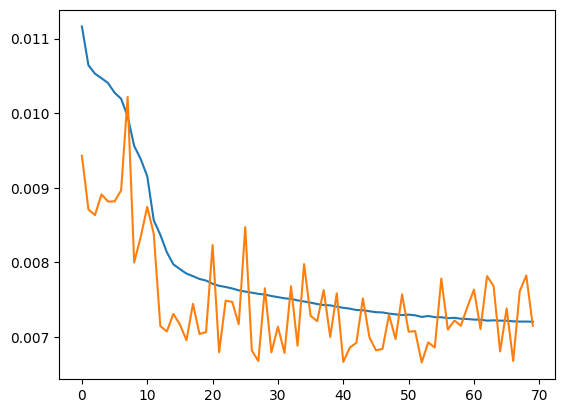

In [38]:
plt.plot(train_losses)
plt.plot(val_losses)

#### Model Eval

In [71]:
best_model = SimpleRNN(6, 32)
best_model.load_state_dict(torch.load('../../training_checkpoints/lat_lon/simplernn_v1p1/best_model.pt'))
best_model.eval()

SimpleRNN(
  (rnn): RNN(6, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)

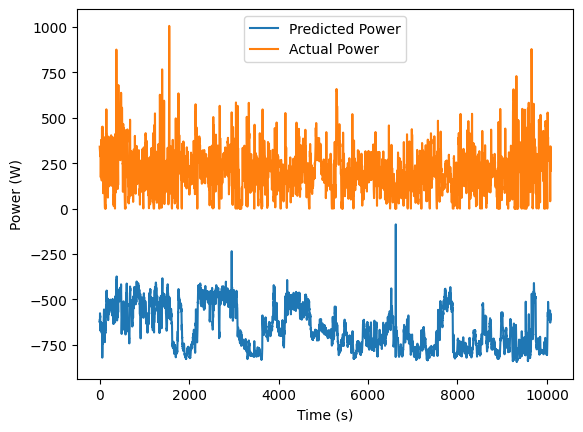

: 

In [72]:
test_activity_dataloader = test_dataloaders[0]

powers = []
pred_powers =  []
for (window, power) in test_activity_dataloader:
    with torch.no_grad():
        power_pred = model(window)
    power_pred = train_dataset.power_scaler.inverse_transform(power_pred.cpu().numpy())
    power = train_dataset.power_scaler.inverse_transform(power.cpu().numpy())
    pred_powers.append(power_pred)
    powers.append(power)

powers = np.array(powers).reshape(-1)
pred_powers = np.array(pred_powers).reshape(-1)


plt.plot(pred_powers, label='Predicted Power')
plt.plot(powers, label='Actual Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend()

In [69]:
print(np.mean(powers))
print(np.mean(pred_powers))

230.88834
-656.094
